In [7]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang", "simtrial")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
cluster <- makeCluster(16)  
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/3m_comparison.R')
source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

# NPH Early Difference

#### Reference: Shan(2021) (https://doi.org/10.1016/j.conctc.2021.100732)
#### But this paper is single arm two stages simple RMST. We are double
#### We use the non-HR setting in Eaton(2020) (One stage two sided test)
-----
## We added a Interim Period Under Non Proportional Hazard
####  $\textcolor{yellow}{H_0 : \lambda_0 = \lambda_1 = 1.2}$    
####  $\textcolor{yellow}{H_1 : \lambda_0 = 1.2,\ \lambda_1 = Piecewise\ Exponential}$
#### HR1 is the hazard ratio before the change_time and HR2 is after

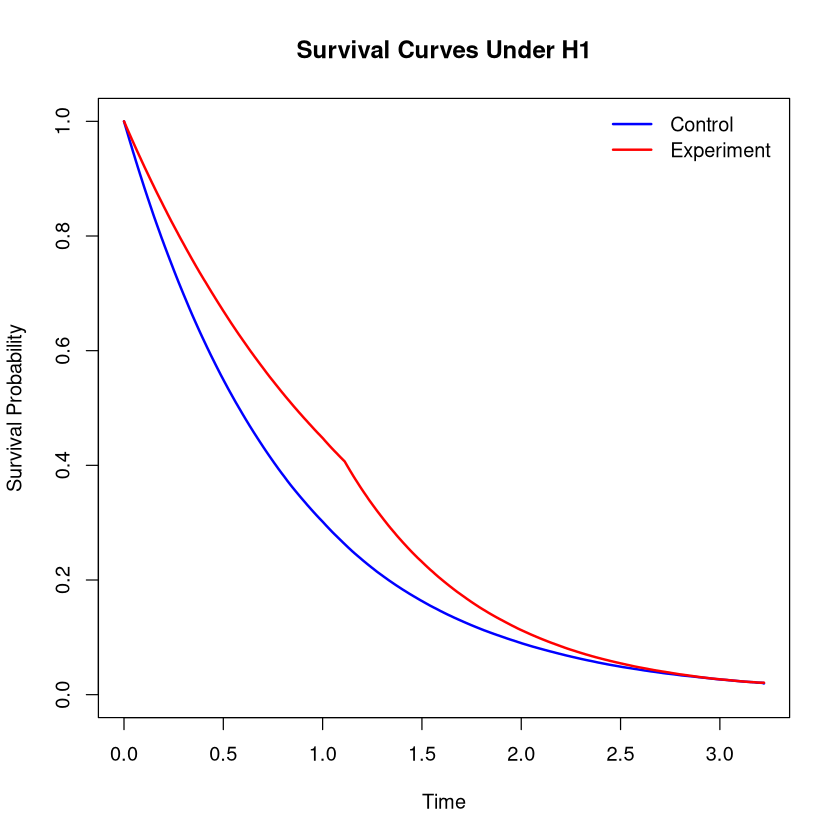

In [8]:
lambda_H0 <- 1.2
HR1 <- 0.67
HR2 <- 1.2
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
change_time <- acc_time * 0.5  # The time point between HR1 and HR2
set.seed(2024)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0,
                         dist = 'exp', cen_time = cen_time, arm = 0, interim = interim)
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                         dist = 'exp', cen_time = cen_time, arm = 1, interim = interim)                         
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                          dist = 'pcw_exp', cen_time = cen_time,HR1 = HR1, HR2 = HR2, 
                          change_time = change_time, arm = 1, interim = interim)

pre_data <- rbind(data_C[ , c(4,5,1)], data_E_H1[ , c(4,5,1)])
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

#calculate the RMST of each group in H0,H1
data_C_int <- data_C[ , c(2,3,1)]  
data_E_H0_int <- data_E_H0[ , c(2,3,1)]
data_E_H1_int <- data_E_H1[ , c(2,3,1)]
rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0_int, data_C = data_C_int,tau = interim,sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1_int, data_C = data_C_int,tau = interim,sim_size = sim_size)

data_C_fin <- data_C[ , c(4,5,1)]
data_E_H0_fin <- data_E_H0[ , c(4,5,1)]
data_E_H1_fin <- data_E_H1[ , c(4,5,1)]
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0_fin, data_C = data_C_fin,tau = 48,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1_fin, data_C = data_C_fin,tau = 48,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

## 1.  Different Hazard Ratio (HR1)
#### $H0: \lambda_E = \lambda_C = 1.2$ is fixed.
#### $H1: \lambda_C = 1.2,\ \lambda_{E1} = 1.2*HR1$, where $\lambda_{E1}$ is the hazard of period 1. 
#### Fix HR2, Change HR1

In [9]:
lambda_H0 <- 1.2
HR2 <- 1.2
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90    # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
change_time <- acc_time * 0.5  # The time point between HR1 and HR2
set.seed(2024)

alpha <- 0.05

diff_hr1_ED <- foreach(HR1 = seq(0.5, 0.95, by = 0.05), .combine = rbind) %dopar%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(HR1, result$alpha, result$power, result$PET0, result$PET1)      
    }


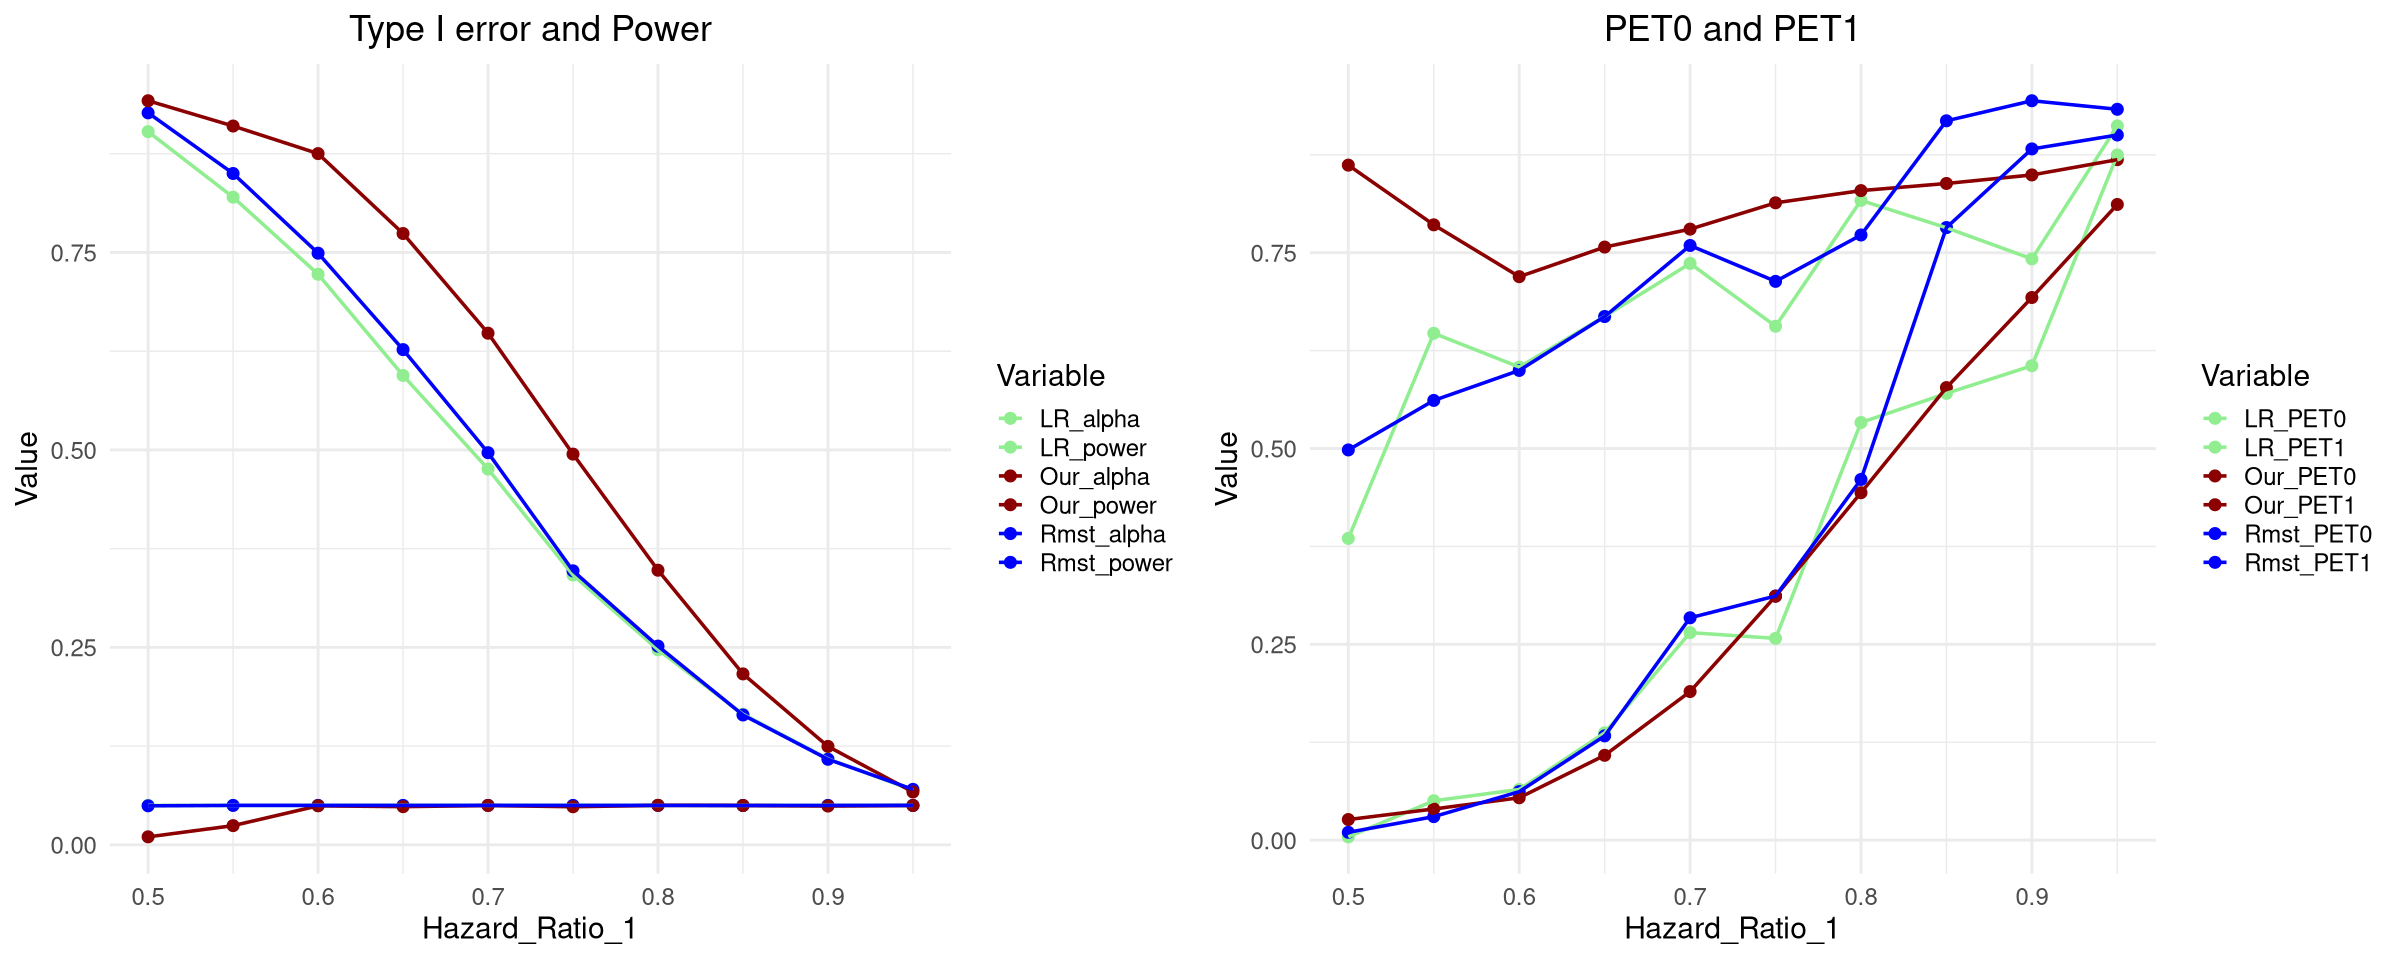

In [10]:
save(diff_hr1_ED, file = '/home/r27user6/RMST_Code/RData/diff_hr1_ED.RData')
load('/home/r27user6/RMST_Code/RData/diff_hr1_ED.RData')
# self-define function for drawing plots
compare_line_plot(data = diff_hr1_ED, var_name = 'Hazard_Ratio_1')

## 2. Different interim period
#### Interim period from 40% to 90% of the whole accrual period
#### The changing point of HR is around 1.5 year

In [11]:
lambda_H0 <- 1.2
HR1 <- 0.67
HR2 <- 1.2
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90    # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
change_time <- acc_time * 0.5  # The time point between HR1 and HR2
set.seed(2024)

alpha <- 0.05

diff_interim_ED <- foreach(int_sam = seq(80, 180, by = 10), .combine = rbind) %dopar%
    {
        interim <- int_sam / r
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(interim, result$alpha, result$power, result$PET0, result$PET1)      
      
    }

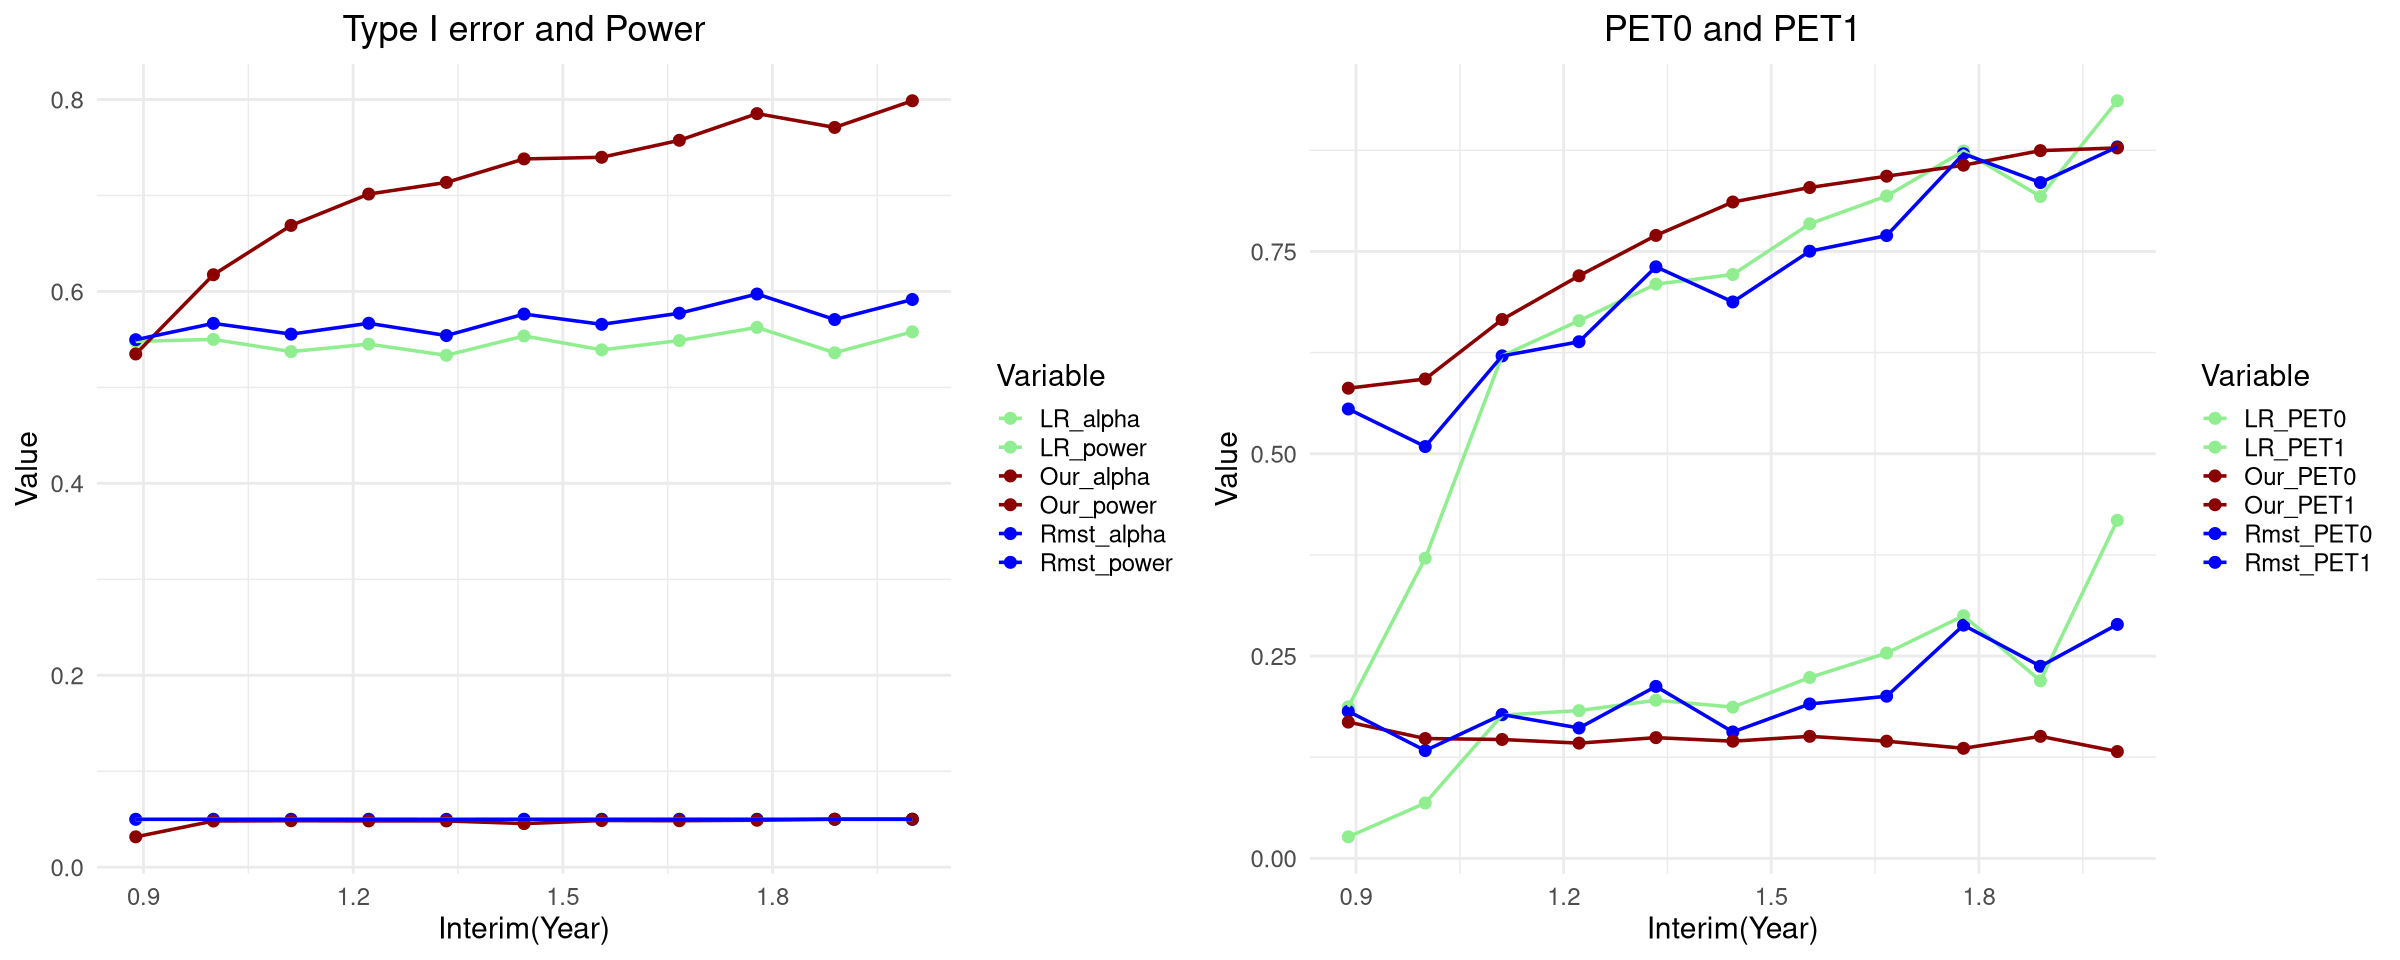

In [12]:
save(diff_interim_ED, file = '/home/r27user6/RMST_Code/RData/diff_interim_ED.RData')
load('/home/r27user6/RMST_Code/RData/diff_interim_ED.RData')

compare_line_plot(data = diff_interim_ED, var_name = 'Interim(Year)')

------
## 3. Different Recruit Rate
### Constant recruit rate. Smaller value means longer accrual time and interim period

In [13]:
lambda_H0 <- 1.2
HR1 <- 0.67
HR2 <- 1.2
sim_size <- 10000 
n <- ceiling(200 / 2) 
cen_time <- 1
change_time <- acc_time * 0.5  # The time point between HR1 and HR2
set.seed(2024)

alpha <- 0.05

diff_rec_rate_ED <- foreach(r = seq(40, 130, by = 10), .combine = rbind) %dopar%
    {
        acc_time <- 200 / r
        interim <- 120 / r 
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(r, result$alpha, result$power, result$PET0, result$PET1)  
    }

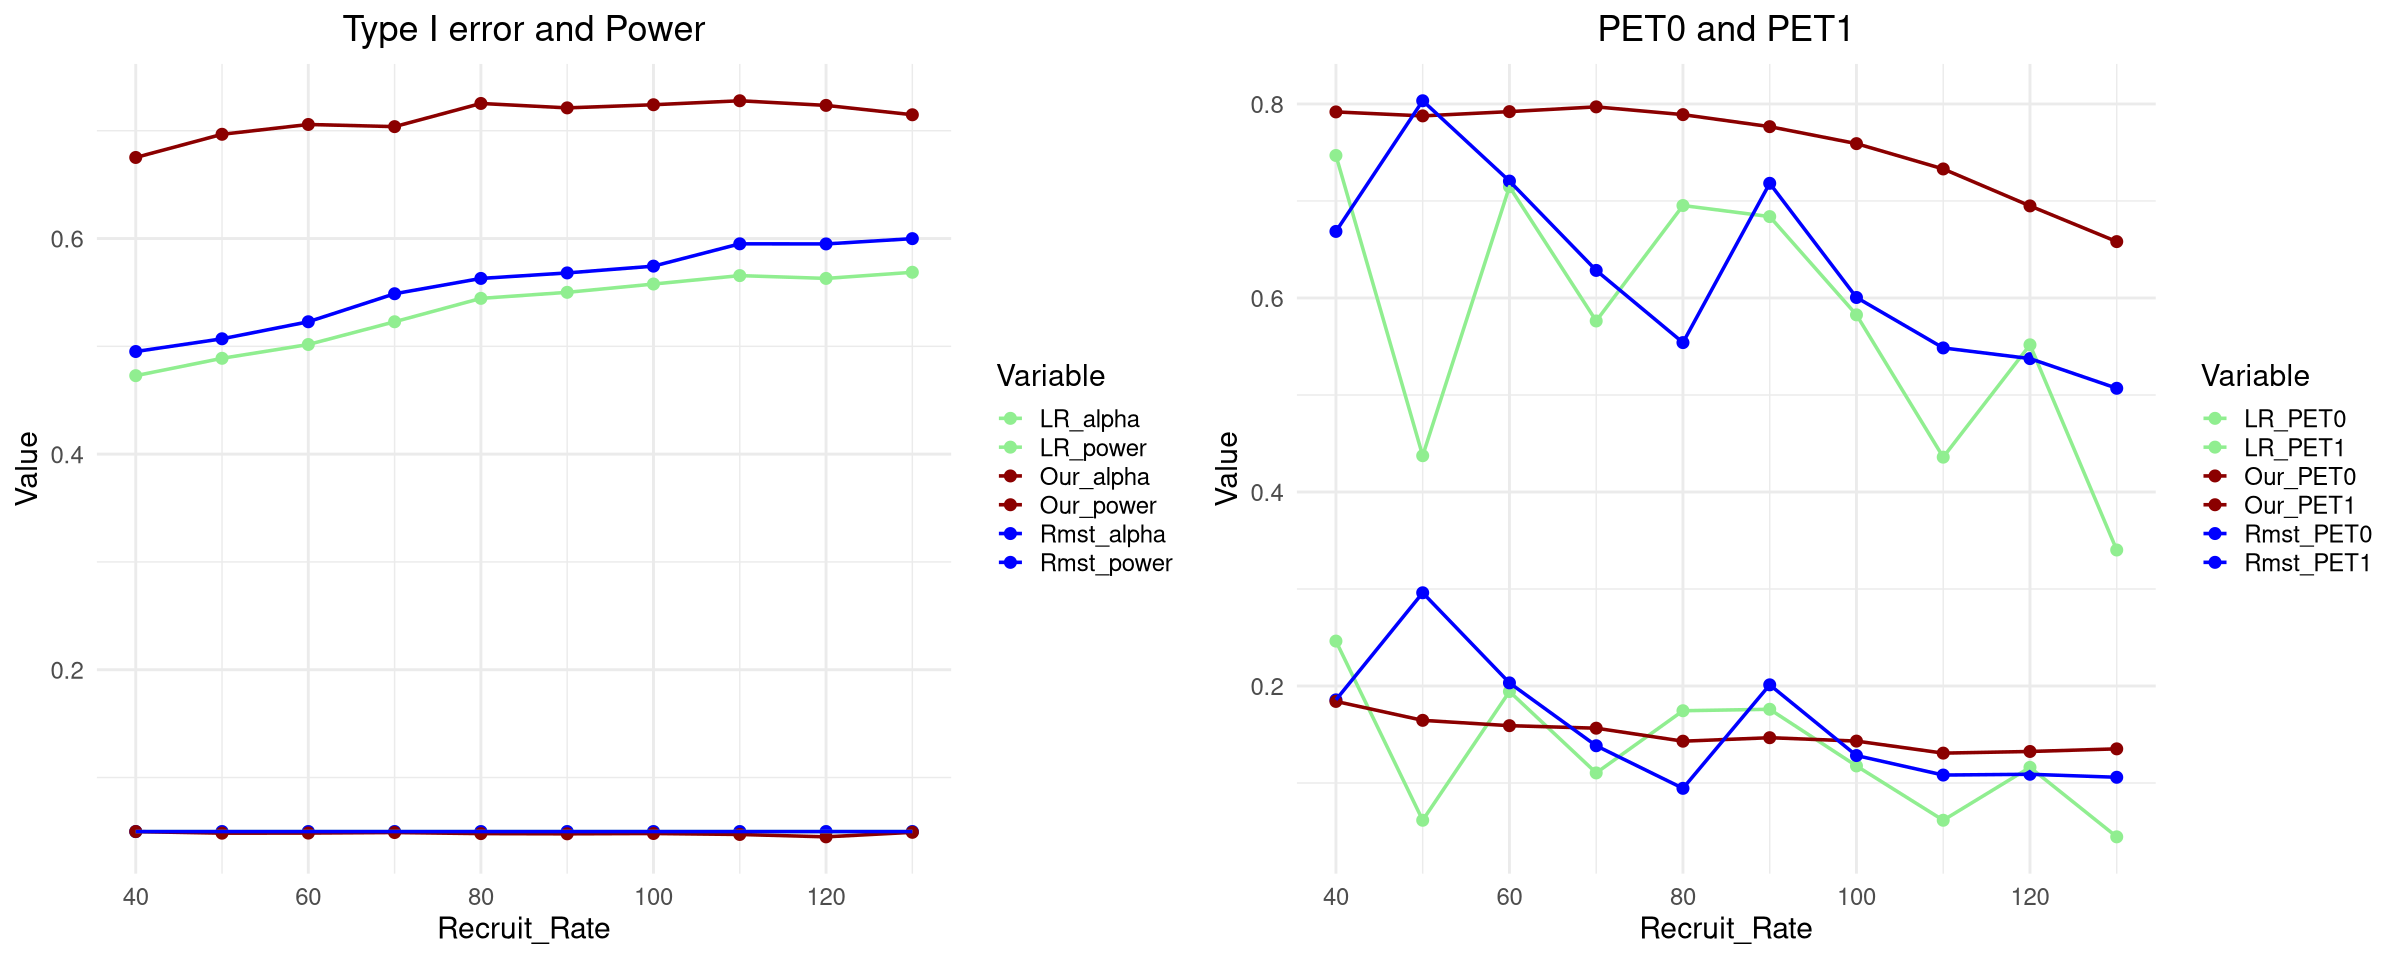

In [14]:
save(diff_rec_rate_ED, file = '/home/r27user6/RMST_Code/RData/diff_rec_rate_ED.RData')
load('/home/r27user6/RMST_Code/RData/diff_rec_rate_ED.RData')

compare_line_plot(data = diff_rec_rate_ED, var_name = 'Recruit_Rate')

------
## 4. Different Changing Point
#### The time point of HR1 to HR2


In [15]:
# lambda_H0 <- 1.2
# HR1 <- 0.67
# HR2 <- 1.2
# sim_size <- 10000 
# n <- ceiling(200 / 2) 
# r <- 90  # patient recruit rate
# acc_time <- 200 / r
# cen_time <- 1
# interim <- 120 / r
# set.seed(2024)

# alpha <- 0.05

# diff_ct_ED <- foreach(ct_rate = seq(0.2, 0.8, by = 0.06), .combine = rbind) %dopar%
#     {
#         change_time <- acc_time * ct_rate
#         result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
#                 interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
#                 HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
#         c(change_time, result$alpha, result$power, result$PET0, result$PET1)  
#     }

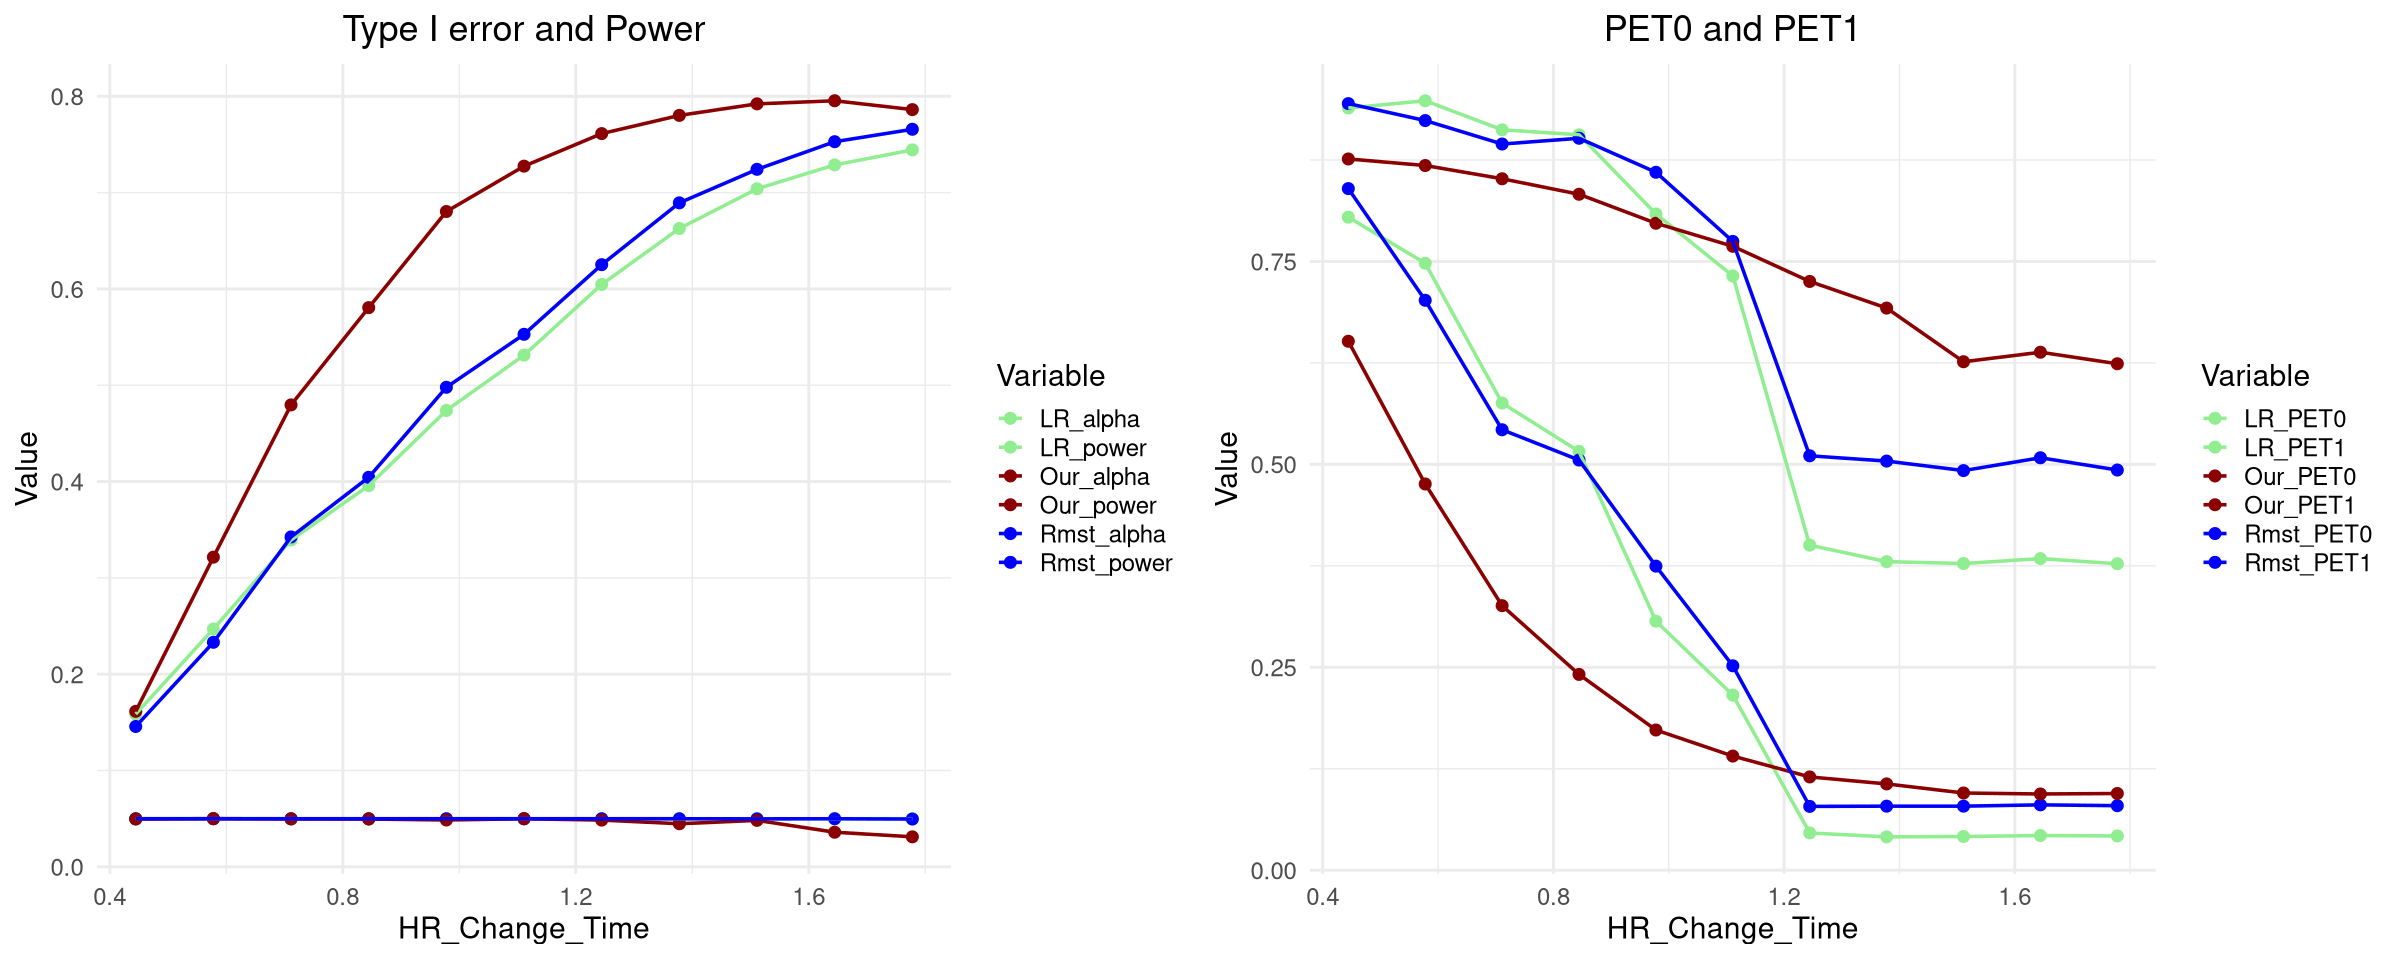

In [16]:
#save(diff_ct_ED, file = '/home/r27user6/RMST_Code/RData/diff_ct_ED.RData')
load('/home/r27user6/RMST_Code/RData/diff_ct_ED.RData')

compare_line_plot(data = diff_ct_ED, var_name = 'HR_Change_Time')

-----
## 5. Different Follow Up Time : censoring distribution
### Censoring distribution $C \sim U [b , a + b]$, where b is the follow up time.
### We tune b from 0.6 to 1.6

In [17]:
lambda_H0 <- 1.2
HR1 <- 0.67
HR2 <- 1.2
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90    # patient recruit rate
acc_time <- 200 / r
interim <- 120 / r
change_time <- acc_time * 0.5  # The time point between HR1 and HR2
set.seed(2024)

alpha <- 0.05

diff_cen_ED <- foreach(cen_time = seq(0.6, 1.5, by = 0.1), .combine = rbind) %dopar%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(cen_time, result$alpha, result$power, result$PET0, result$PET1)        
    }

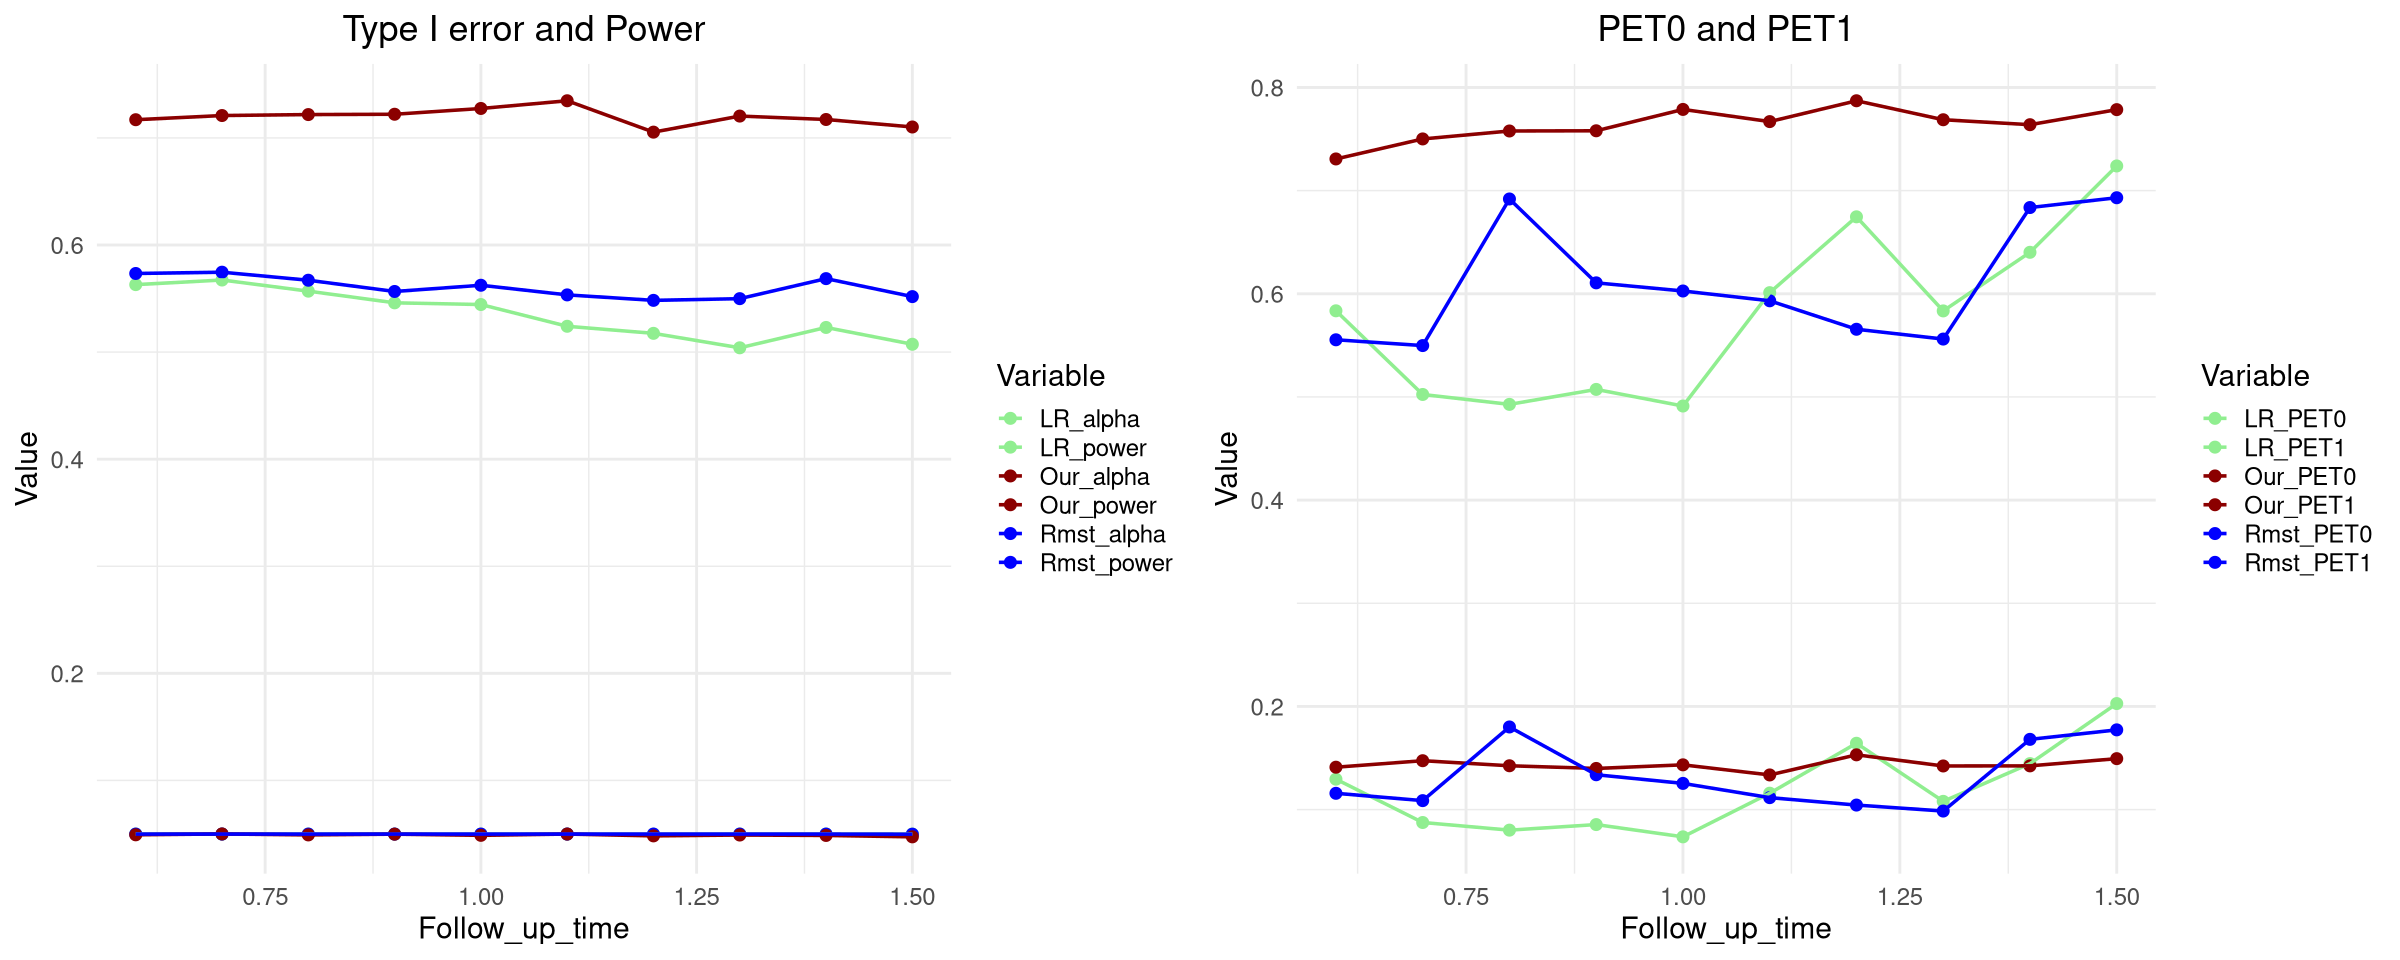

In [18]:
save(diff_cen_ED, file = '/home/r27user6/RMST_Code/RData/diff_cen_ED.RData')
load('/home/r27user6/RMST_Code/RData/diff_cen_ED.RData')

compare_line_plot(data = diff_cen_ED, var_name = 'Follow_up_time')